# Notebook to compare a new mechanism to Aramco butane

In [1]:
import os
import sys
import numpy as np
import pydot
import rmgpy.tools.fluxdiagram
import rmgpy.chemkin
import copy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



sys.path.append('/home/moon/autoscience/autoscience_workflow/database')
import database_fun

Loading DFT database from /home/moon/autoscience/autoscience_workflow/database


### Settings

In [2]:
# Options controlling the individual flux diagram renderings:
program = 'dot'  # The program to use to lay out the nodes and edges
max_node_count = 50  # The maximum number of nodes to show in the diagram
max_edge_count = 50  # The maximum number of edges to show in the diagram
concentration_tol = 1e-6  # The lowest fractional concentration to show (values below this will appear as zero)
species_rate_tol = 1e-6  # The lowest fractional species rate to show (values below this will appear as zero)
max_node_pen_width = 7.0  # The thickness of the border around a node at maximum concentration
max_edge_pen_width = 9.0  # The thickness of the edge at maximum species rate
radius = 1  # The graph radius to plot around a central species
central_reaction_count = None  # The maximum number of reactions to draw from each central species (None draws all)
# If radius > 1, then this is the number of reactions from every species

# Options controlling the ODE simulations:
initial_time = 1e-12  # The time at which to initiate the simulation, in seconds
time_step = 10 ** 0.1  # The multiplicative factor to use between consecutive time points
abs_tol = 1e-16  # The absolute tolerance to use in the ODE simluations
rel_tol = 1e-8  # The relative tolerance to use in the ODE simulations

# Options controlling the generated movie:
video_fps = 6  # The number of frames per second in the generated movie
initial_padding = 5  # The number of seconds to display the initial fluxes at the start of the video
final_padding = 5  # The number of seconds to display the final fluxes at the end of the video


# species_path = None
java = False            # always False
settings = None
chemkin_output = ''     # this will be generated automatically
central_species_list = None
superimpose = False     # this will always be false, delete it
save_states = False
read_states = False     # fine to keep this always false and delete relevant code below
diffusion_limited = True
check_duplicates = True

### Load Mechanisms

In [3]:
# rmg_input_file = '/home/moon/autoscience/fuels/simplified_input_959.py'  # for conditions T = 959, P = 10 atm
rmg_input_file = '/home/moon/autoscience/fuels/simplified_input.py'  # for conditions T = 830, P = 10 atm



diagram_base_name = 'current_vs_20240423'
os.makedirs(diagram_base_name, exist_ok=True)

mech_1_inp = '/home/moon/autoscience/compare_to_aramco/rmg_min_4/chem_annotated.inp'
mech_1_dict = '/home/moon/autoscience/compare_to_aramco/rmg_min_4/species_dictionary.txt'
mech_1_label = 'RMG-min-4'
t1_ignition = 0.06535855787324196  # the ignition time for Aramco


# --------------------------------- EDIT THIS ----------------------------
mech_2_inp = '/home/moon/autoscience/compare_to_aramco/rmg_min_4_20240423/chem_annotated.inp'
mech_2_dict = '/home/moon/autoscience/compare_to_aramco/rmg_min_4_20240423/species_dictionary.txt'
mech_2_label = 'RMG-min-4 20240423'
t2_ignition = 0.06535855787324196  # still manually entered

# diagram_base_name = 'concat_compare_ks'
# os.makedirs(diagram_base_name, exist_ok=True)

# mech_1_inp = '/home/moon/autoscience/compare_to_aramco/concat_compare/chem_4p0.inp'
# mech_1_dict = '/home/moon/autoscience/compare_to_aramco/concat_compare/species_dictionary.txt'
# mech_1_label = 'k4.0'
# t1_ignition = 0.06535855787324196  # the ignition time for Aramco


# # --------------------------------- EDIT THIS ----------------------------
# mech_2_inp = '/home/moon/autoscience/compare_to_aramco/concat_compare/chem_7p0.inp'
# mech_2_dict = '/home/moon/autoscience/compare_to_aramco/concat_compare/species_dictionary.txt'
# mech_2_label = 'k7.0'
# t2_ignition = 0.06535855787324196  # still manually entered


# diagram_base_name = 'flux_diagram_mins'
# os.makedirs(diagram_base_name, exist_ok=True)

# mech_1_inp = '/home/moon/autoscience/compare_to_aramco/rmg_min_3/chem_annotated.inp'
# mech_1_dict = '/home/moon/autoscience/compare_to_aramco/rmg_min_3/species_dictionary.txt'
# mech_1_label = 'RMG-min-3'
# t1_ignition = 0.06535855787324196  # the ignition time for Aramco


# # --------------------------------- EDIT THIS ----------------------------
# mech_2_inp = '/home/moon/autoscience/compare_to_aramco/rmg_min_4/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/compare_to_aramco/rmg_min_4/species_dictionary.txt'
# mech_2_label = 'RMG-min-4'
# t2_ignition = 0.06535855787324196  # still manually entered


generate_images = False
species_path = '/home/moon/autoscience/fuels/species'
print('Loading RMG job 1...')
rmg_job1 = rmgpy.tools.fluxdiagram.load_rmg_job(
    rmg_input_file,
    mech_1_inp,
    mech_1_dict,
    generate_images=generate_images,
    check_duplicates=check_duplicates
)

print('Loading RMG job 2...')
rmg_job2 = rmgpy.tools.fluxdiagram.load_rmg_job(
    rmg_input_file,
    mech_2_inp,
    mech_2_dict,
    generate_images=generate_images,
    check_duplicates=check_duplicates
)


Loading RMG job 1...


Loading RMG job 2...


### Simulation

In [4]:
print('Conducting simulation of reaction 1')
times1, concentrations1, reaction_rates1 = rmgpy.tools.fluxdiagram.simulate(
    rmg_job1.reaction_model,
    rmg_job1.reaction_systems[0],
    settings
)

print('Conducting simulation of reaction 2')
times2, concentrations2, reaction_rates2 = rmgpy.tools.fluxdiagram.simulate(
    rmg_job2.reaction_model,
    rmg_job2.reaction_systems[0],
    settings
)


Conducting simulation of reaction 1
Conducting simulation of reaction 2


In [5]:
times1.shape

(121,)

In [6]:
times1[-3]

0.6311858602617695

### Compute/assemble species concentrations and fluxes into convenient form

In [7]:
# Get the RMG species and reactions objects
species_list1 = rmg_job1.reaction_model.core.species[:]
reaction_list1 = rmg_job1.reaction_model.core.reactions[:]
num_species1 = len(species_list1)

species_list2 = rmg_job2.reaction_model.core.species[:]
reaction_list2 = rmg_job2.reaction_model.core.reactions[:]
num_species2 = len(species_list2)


In [8]:
# Compute the rates between each pair of species (build up big matrices)
species_rates1 = np.zeros((len(times1), num_species1, num_species1), float)
for index1, reaction1 in enumerate(reaction_list1):
    rate1 = reaction_rates1[:, index1]
    if not reaction1.pairs: reaction1.generate_pairs()
    for reactant1, product1 in reaction1.pairs:
        reactant_index1 = species_list1.index(reactant1)
        product_index1 = species_list1.index(product1)
        species_rates1[:, reactant_index1, product_index1] += rate1
        species_rates1[:, product_index1, reactant_index1] -= rate1
        
species_rates2 = np.zeros((len(times2), num_species2, num_species2), float)
for index2, reaction2 in enumerate(reaction_list2):
    rate2 = reaction_rates2[:, index2]
    if not reaction2.pairs: reaction2.generate_pairs()
    for reactant2, product2 in reaction2.pairs:
        reactant_index2 = species_list2.index(reactant2)
        product_index2 = species_list2.index(product2)
        species_rates2[:, reactant_index2, product_index2] += rate2
        species_rates2[:, product_index2, reactant_index2] -= rate2

In [9]:
# Determine the maximum concentration for each species and the maximum overall concentration
max_concentrations1 = np.max(np.abs(concentrations1), axis=0)
max_concentration1 = np.max(max_concentrations1)

# Determine the maximum reaction rates
max_reaction_rates1 = np.max(np.abs(reaction_rates1), axis=0)

# Determine the maximum rate for each species-species pair and the maximum overall species-species rate
max_species_rates1 = np.max(np.abs(species_rates1), axis=0)
max_species_rate1 = np.max(max_species_rates1)
species_index1 = max_species_rates1.reshape((num_species1 * num_species1)).argsort()


max_concentrations2 = np.max(np.abs(concentrations2), axis=0)
max_concentration2 = np.max(max_concentrations2)

# Determine the maximum reaction rates
max_reaction_rates2 = np.max(np.abs(reaction_rates2), axis=0)

# Determine the maximum rate for each species-species pair and the maximum overall species-species rate
max_species_rates2 = np.max(np.abs(species_rates2), axis=0)
max_species_rate2 = np.max(max_species_rates2)
species_index2 = max_species_rates2.reshape((num_species2 * num_species2)).argsort()


max_species_rate_total = max(max_species_rate1, max_species_rate2)
max_concentration_total = max(max_concentration1, max_concentration2)

### Determine nodes and edges to include for each model

In [10]:
nodes1 = []
edges1 = []
for i in range(num_species1 * num_species1):
    product_index1, reactant_index1 = divmod(species_index1[-i - 1], num_species1)
    if reactant_index1 > product_index1:
        # Both reactant -> product and product -> reactant are in this list, so only keep one of them
        continue
    if max_species_rates1[reactant_index1, product_index1] == 0:
        break
    if reactant_index1 not in nodes1 and len(nodes1) < max_node_count: nodes1.append(reactant_index1)
    if product_index1 not in nodes1 and len(nodes1) < max_node_count: nodes1.append(product_index1)
    if [reactant_index1, product_index1] not in edges1 and [product_index1, reactant_index1] not in edges1:
        edges1.append([reactant_index1, product_index1])
    if len(nodes1) > max_node_count:
        break
    if len(edges1) >= max_edge_count:
        break
        
nodes2 = []
edges2 = []
for i in range(num_species2 * num_species2):
    product_index2, reactant_index2 = divmod(species_index2[-i - 1], num_species2)
    if reactant_index2 > product_index2:
        # Both reactant -> product and product -> reactant are in this list, so only keep one of them
        continue
    if max_species_rates2[reactant_index2, product_index2] == 0:
        break
    if reactant_index2 not in nodes2 and len(nodes2) < max_node_count: nodes2.append(reactant_index2)
    if product_index2 not in nodes2 and len(nodes2) < max_node_count: nodes2.append(product_index2)
    if [reactant_index2, product_index2] not in edges2 and [product_index2, reactant_index2] not in edges2:
        edges2.append([reactant_index2, product_index2])
    if len(nodes2) > max_node_count:
        break
    if len(edges2) >= max_edge_count:
        break
  

### create mapping between models

In [11]:
species2_to_1 = {}
species2_to_1 = {key: value for key, value in zip([x for x in range(len(species_list1))], [-1] * len(species_list1))}
for i in range(len(species_list2)):
    for j in range(len(species_list1)):
        if species_list2[i].is_isomorphic(species_list1[j]):
            species2_to_1[i] = j
            break
    else:
        species2_to_1[i] = -1

species1_to_2 = {}
species1_to_2 = {key: value for key, value in zip([x for x in range(len(species_list1))], [-1] * len(species_list1))}
for i in range(len(species_list1)):
    for j in range(len(species_list2)):
        if species_list1[i].is_isomorphic(species_list2[j]):
            species1_to_2[i] = j
            break
    else:
        species1_to_2[i] = -1


In [12]:
# Function to grab and generate the image for a given species
def get_image_path(species):
    species_index = str(species) + '.png'
    image_path = ''
    if not species_path or not os.path.exists(species_path):  # species_path is defined while loading the mechanism
        raise OSError
    for root, dirs, files in os.walk(species_path):
        for f in files:
            if f == species_index:
                image_path = os.path.join(root, f)
                break
    if not image_path:
        image_path = os.path.join(species_path, species_index)
        species.molecule[0].draw(image_path)
    return image_path

### Build the graph

In [13]:
# Create the graph
rmg1_color = matplotlib.colors.to_hex((1.0, 0.92, 0.0))
rmg1_color = matplotlib.colors.to_hex(matplotlib.colors.CSS4_COLORS['lawngreen'])
rmg7_color = matplotlib.colors.to_hex(matplotlib.colors.CSS4_COLORS['lawngreen'])
aramco_color = matplotlib.colors.to_hex((0.18627451, 0.48823529, 0.94117647))
aramco_color = matplotlib.colors.to_hex(matplotlib.colors.CSS4_COLORS['fuchsia'])
# add alpha specified by adding hex digits before RGB values
alpha = 0.9
alpha_hex = hex(int(alpha * 255))[2:]
aramco_color = f'#{aramco_color[1:]}{alpha_hex}'
rmg1_color = f'#{rmg1_color[1:]}{alpha_hex}'
rmg7_color = f'#{rmg7_color[1:]}{alpha_hex}'

# Grab the fluxes from the time closest (without going over) to official ignition delay time
t1 = np.abs(times1 - t1_ignition).argmin()
if times1[t1] > t1_ignition:
    t1 -= 1
t2 = np.abs(times2 - t2_ignition).argmin()
if times2[t2] > t2_ignition:
    t2 -= 1



label_automatically = False  # Turned off because manual labels upset the graph placements less
assert -1 not in nodes1
assert -1 not in nodes2

for t in range(len(times1))[::2]:

    t1 = t
    t2 = t
    slope = -max_node_pen_width / np.log10(concentration_tol)
    graph = pydot.Dot('flux_diagram', graph_type='digraph', overlap="false")
    graph.set_fontname('sans')
    graph.set_fontsize('10')

    # ----------------------------ADD NODES ------------------------------#
    # For Mechanism 1
    for index1 in nodes1:
        nodewidths = np.zeros(3)  # keep track of species concentrations/nodewidths for all 3 mechanisms
        species1 = species_list1[index1]
        node1 = pydot.Node(name=str(species1))
        concentration1 = concentrations1[t1, index1] / max_concentration_total
        if concentration1 < concentration_tol:
            penwidth = 0.0
        else:
            penwidth = round(slope * np.log10(concentration1) + max_node_pen_width, 3)
            nodewidths[0] = penwidth
        node1.set_penwidth(penwidth)
        node1.set_fillcolor('white')
        node1.set_color(aramco_color)
        image_path1 = get_image_path(species1)
        if os.path.exists(image_path1):
            node1.set_image(image_path1)
            node1.set_label("")

        index2 = species1_to_2[index1]
        if index2 >= 0:
            concentration2 = concentrations2[t2, index2] / max_concentration_total
            if concentration2 < concentration_tol:
                penwidth = 0.0
            else:
                penwidth = round(slope * np.log10(concentration2) + max_node_pen_width, 3)
                nodewidths[1] = penwidth
                if node1.get_penwidth() > 0:
                    node1.set_color('black')
                else:
                    node1.set_color(rmg1_color)
                    node1.set_penwidth(penwidth)


        if node1.get_color() == 'black':
            node1.set_penwidth(np.average(nodewidths))
        graph.add_node(node1)

    # For Mechanism 2
    for index2 in nodes2:
        if species2_to_1[index2] in nodes1:
            continue  # already took care of it above

        nodewidths = np.zeros(3)
        species2 = species_list2[index2]
        node2 = pydot.Node(name=str(species2))
        concentration2 = concentrations2[t2, index2] / max_concentration_total
        if concentration2 < concentration_tol:
            penwidth = 0.0
        else:
            penwidth = round(slope * np.log10(concentration2) + max_node_pen_width, 3)
            nodewidths[1] = penwidth
        node2.set_fillcolor('white')
        node2.set_color(rmg1_color)
        node2.set_penwidth(penwidth)
        # Try to use an image instead of the label
        image_path2 = get_image_path(species2)
        if os.path.exists(image_path2):
            node2.set_image(image_path2)
            node2.set_label("")


        if node2.get_color() == 'black':
            node2.set_penwidth(np.average(nodewidths))

        graph.add_node(node2)



    # ------------------------------- EDGES ------------------------------#
    # Add an edge for each species-species rate
    slope = -max_edge_pen_width / np.log10(species_rate_tol)

    # Go through edges in Mechanism 1
    for reactant_index1, product_index1 in edges1:
        if reactant_index1 in nodes1 and product_index1 in nodes1:
            reactant1 = species_list1[reactant_index1]
            product1 = species_list1[product_index1]
            label1 = ''

            edge1 = pydot.Edge(str(reactant1), str(product1), color=aramco_color)
            species_rate1 = species_rates1[t1, reactant_index1, product_index1] / max_species_rate_total
            if species_rate1 < 0:
                edge1.set_dir("back")
                species_rate1 = -species_rate1
            else:
                edge1.set_dir("forward")
            # Set the edge pen width
            if species_rate1 < species_rate_tol:
                penwidth = 0.0
                edge1.set_dir("none")
            else:
                penwidth = round(slope * np.log10(species_rate1) + max_edge_pen_width, 3)
            edge1.set_penwidth(penwidth)
            if label1 and label_automatically:
                edge1.set_decorate(True)
                edge1.set_label(label1)

            graph.add_edge(edge1)

            # add mech 2
            if species1_to_2[reactant_index1] >= 0 and species1_to_2[product_index1] >= 0:
                reactant_index2 = species1_to_2[reactant_index1]
                product_index2 = species1_to_2[product_index1]

                edge2 = pydot.Edge(str(reactant1), str(product1), color=rmg1_color)
                species_rate2 = species_rates2[t2, reactant_index2, product_index2] / max_species_rate_total
                if species_rate2 < 0:
                    edge2.set_dir("back")
                    species_rate2 = -species_rate2
                else:
                    edge2.set_dir("forward")
                # Set the edge pen width
                if species_rate2 < species_rate_tol:
                    penwidth = 0.0
                    edge2.set_dir("none")
                else:
                    penwidth = round(slope * np.log10(species_rate2) + max_edge_pen_width, 3)
                edge2.set_penwidth(penwidth)
                graph.add_edge(edge2)

    # Go through edges in Mechanism 2
    for reactant_index2, product_index2 in edges2:
        # skip if this was already done in edges 1
        if [species2_to_1[reactant_index2], species2_to_1[product_index2]] in edges1 or \
            [species2_to_1[product_index2], species2_to_1[reactant_index2]] in edges1:
            continue

        if reactant_index2 in nodes2 and product_index2 in nodes2:
            # mech 2 says include this edge for all mechs
            if species2_to_1[reactant_index2] in nodes1:
                reactant2 = species_list1[species2_to_1[reactant_index2]]
            else:
                reactant2 = species_list2[reactant_index2]
            if species2_to_1[product_index2] in nodes1:
                product2 = species_list1[species2_to_1[product_index2]]
            else:
                product2 = species_list2[product_index2]
            edge2 = pydot.Edge(str(reactant2), str(product2), color=rmg1_color)

            species_rate2 = species_rates2[t2, reactant_index2, product_index2] / max_species_rate_total
            if species_rate2 < 0:
                edge2.set_dir("back")
                species_rate2 = -species_rate2
            else:
                edge2.set_dir("forward")
            # Set the edge pen width
            if species_rate2 < species_rate_tol:
                penwidth = 0.0
                edge2.set_dir("none")
            else:
                penwidth = round(slope * np.log10(species_rate2) + max_edge_pen_width, 3)



            edge2.set_penwidth(penwidth)
            graph.add_edge(edge2)

            # add mech 1
            if species2_to_1[reactant_index2] >= 0 and species2_to_1[product_index2] >= 0:
                reactant_index1 = species2_to_1[reactant_index2]
                product_index1 = species2_to_1[product_index2]

                edge1 = pydot.Edge(str(reactant2), str(product2), color=aramco_color)
                species_rate1 = species_rates1[t1, reactant_index1, product_index1] / max_species_rate_total
                if species_rate1 < 0:
                    edge1.set_dir("back")
                    species_rate1 = -species_rate1
                else:
                    edge1.set_dir("forward")
                # Set the edge pen width
                if species_rate1 < species_rate_tol:
                    penwidth = 0.0
                    edge1.set_dir("none")
                else:
                    penwidth = round(slope * np.log10(species_rate1) + max_edge_pen_width, 3)
                edge1.set_penwidth(penwidth)
                label2 = ''
                if label2 and label_automatically:
                    edge1.set_decorate(True)
                    edge1.set_label(label2)
                graph.add_edge(edge1)


    # General purpose graph settings
    graph.set_nodesep(0.11)
    graph.set_ranksep(0.35)
    graph.set_rankdir('LR')

    # Add Legend
    graph.add_node(pydot.Node(mech_1_label + f'\nt={times1[t1]:.4e}', label=mech_1_label + f'\nt={times1[t1]:.4e}', color=aramco_color, shape='box', penwidth=max_node_pen_width))
    graph.add_node(pydot.Node(mech_2_label + f'\nt={times2[t2]:.4e}', label=mech_2_label + f'\nt={times2[t2]:.4e}', color=rmg1_color, shape='box', penwidth=max_node_pen_width))


    # write in multiple formats
    graph.write_dot(os.path.join(diagram_base_name, f'{diagram_base_name}_{t1}.dot')) # Yes this is supposed to be an index, not an actual time
    graph.write_png(os.path.join(diagram_base_name, f'{diagram_base_name}_{t1}.png'))
    # graph.write_pdf(os.path.join(diagram_base_name, f'{diagram_base_name}_{t1}.pdf'))
    # graph.write_pdf(os.path.join(diagram_base_name, f'{diagram_base_name}_{t1}.svg'))




In [22]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return -1

In [43]:
sp70 = species_list2[get_i_thing(rmgpy.species.Species(smiles='C[CH]CCOO'), species_list2)]
sp68 = species_list2[get_i_thing(rmgpy.species.Species(smiles='CC1CCO1'), species_list2)]

PC4H9 = species_list2[get_i_thing(rmgpy.species.Species(smiles='[CH2]CCC'), species_list2)]
butane = species_list2[get_i_thing(rmgpy.species.Species(smiles='CCCC'), species_list2)]

OH = species_list2[get_i_thing(rmgpy.species.Species(smiles='[OH]'), species_list2)]
HO2 = species_list2[get_i_thing(rmgpy.species.Species(smiles='O[O]'), species_list2)]
H2O2 = species_list2[get_i_thing(rmgpy.species.Species(smiles='OO'), species_list2)]

for i in range(len(reaction_list2)):
    
    if sp68 in reaction_list2[i].reactants + reaction_list2[i].products:
        print(i, reaction_list2[i])
    
#     if sp70 in reaction_list2[i].reactants and sp68 in reaction_list2[i].products or \
#             sp68 in reaction_list2[i].reactants and sp70 in reaction_list2[i].products:
        
# #         if HO2 in reaction_list2[i].reactants + reaction_list2[i].products or H2O2 in reaction_list2[i].reactants + reaction_list2[i].products:
        
#         print(i, reaction_list2[i])
    
    
#     print(reaction_list2[i])

853 O2(2) + C[CH]CC(23)(18) <=> OH(15) + CC1CCO1(68)
854 CCC(C)O[O](43) <=> OH(15) + CC1CCO1(68)
855 [CH2]CC(C)OO(62) <=> OH(15) + CC1CCO1(68)
856 HO2(16) + C4H8(47)(20) <=> OH(15) + CC1CCO1(68)
857 HO2(16) + CC=CC(35) <=> OH(15) + CC1CCO1(68)
858 HO2(16) + C4H8(47)(20) <=> OH(15) + CC1CCO1(68)
859 O2(2) + [CH2]CCC(24)(19) <=> OH(15) + CC1CCO1(68)
860 CCCCO[O](215)(22) <=> OH(15) + CC1CCO1(68)
861 C[CH]CCOO(335) <=> OH(15) + CC1CCO1(68)
862 [CH2]CCCOO(336) <=> OH(15) + CC1CCO1(68)
863 CC1CCO1(68) <=> CH2O(9) + C3H6(12)
864 CC1CCO1(68) <=> C2H4(11) + CC=O(376)
865 OH(15) + CC1CCO1(68) <=> [O]CCCCO(365)
866 OH(15) + CC1CCO1(68) <=> CH2O(9) + [CH2]CCO(2744)
870 OH(15) + CC1CCO1(68) <=> O(5) + CCC(C)[O](44)
871 OH(15) + CC1CCO1(68) <=> O(5) + CCCC[O](330)
872 OH(15) + CC1CCO1(68) <=> O(5) + [CH2]CCCO(2485)
928 [CH2]CC(C)[O](71) <=> CC1CCO1(68)
929 O2(2) + CC1CCO1(68) <=> O2(2) + [CH2]CC(C)[O](71)
930 OH(15) + CC1CCO1(68) <=> OH(15) + [CH2]CC(C)[O](71)
931 HO2(16) + CC1CCO1(68) <=> HO2(16) 

In [44]:
database_fun.get_unique_reaction_index(reaction_list2[864])

452

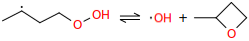

In [39]:
database_fun.index2reaction(449)

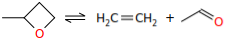

In [45]:
database_fun.index2reaction(452)

In [41]:
get_i_thing(database_fun.index2reaction(449), reaction_list1)

-1

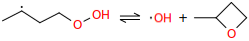

In [37]:
reaction_list2[861]

In [33]:
len(reaction_list2)

2930

In [42]:
print(reaction_list2[861])

C[CH]CCOO(335) <=> OH(15) + CC1CCO1(68)


In [15]:
PC4H9 = species_list2[get_i_thing(rmgpy.species.Species(smiles='[CH2]CCC'), species_list2)]
butane = species_list2[get_i_thing(rmgpy.species.Species(smiles='CCCC'), species_list2)]

HO2 = species_list2[get_i_thing(rmgpy.species.Species(smiles='O[O]'), species_list2)]
H2O2 = species_list2[get_i_thing(rmgpy.species.Species(smiles='OO'), species_list2)]

for i in range(len(reaction_list2)):

    
    if butane in reaction_list2[i].reactants and PC4H9 in reaction_list2[i].products or \
            PC4H9 in reaction_list2[i].reactants and butane in reaction_list2[i].products:
        
        if HO2 in reaction_list2[i].reactants + reaction_list2[i].products or H2O2 in reaction_list2[i].reactants + reaction_list2[i].products:
        
            print(i, reaction_list2[i])
    
    
#     print(reaction_list2[i])

93 HO2(16) + [CH2]CCC(24)(19) <=> O2(2) + butane(1)
96 H2O2(17) + [CH2]CCC(24)(19) <=> HO2(16) + butane(1)


In [16]:
database_fun.get_unique_reaction_index(reaction_list2[82])

4767

In [17]:
len(reaction_list1)

1036

In [18]:
len(reaction_list2)

2930

In [19]:
len(species_list1)

148

In [20]:
len(species_list2)

146

In [40]:
reaction_list2[82].kinetics

Arrhenius(A=(1.7739,'cm^3/(mol*s)'), n=3.328, Ea=(1.143,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [H2O2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")

In [41]:
get_i_thing(reaction_list2[82], reaction_list1)

82

In [42]:
reaction_list1[82].kinetics

Arrhenius(A=(0.0641522,'cm^3/(mol*s)'), n=3.951, Ea=(-21.281,'kcal/mol'), T0=(1,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.24987, dn = +|- 0.0293029, dEa = +|- 0.159466 kJ/mol""")

In [43]:
reaction_list1[82]

In [44]:
reaction_list2[82]

In [21]:
def get_reverse_reaction(reaction):
    assert reaction.kinetics is not None
    rev_reaction = copy.deepcopy(reaction)
    tmp_reactants = rev_reaction.reactants
    rev_reaction.reactants = rev_reaction.products
    rev_reaction.products = tmp_reactants
    rev_reaction.kinetics = reaction.generate_reverse_rate_coefficient()
    return rev_reaction

In [50]:
get_reverse_reaction(reaction_list1[82]).kinetics

Arrhenius(A=(2.76496e-07,'m^3/(mol*s)'), n=4.18682, Ea=(-32.7841,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.16301, dn = +|- 0.0199922, dEa = +|- 0.104515 kJ/mol""")

In [52]:
get_reverse_reaction(reaction_list2[82]).kinetics

Arrhenius(A=(7.6455e-06,'m^3/(mol*s)'), n=3.56382, Ea=(61.0379,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.16301, dn = +|- 0.0199922, dEa = +|- 0.104515 kJ/mol""")

In [ ]:
rmgpy.chemkin.load_chemkin_file()

In [19]:
SC4H9 = species_list2[get_i_thing(rmgpy.species.Species(smiles='C[CH]CC'), species_list2)]
butane = species_list2[get_i_thing(rmgpy.species.Species(smiles='CCCC'), species_list2)]

HO2 = species_list2[get_i_thing(rmgpy.species.Species(smiles='O[O]'), species_list2)]
H2O2 = species_list2[get_i_thing(rmgpy.species.Species(smiles='OO'), species_list2)]

for i in range(len(reaction_list2)):

    
    if butane in reaction_list2[i].reactants and SC4H9 in reaction_list2[i].products or \
            SC4H9 in reaction_list2[i].reactants and butane in reaction_list2[i].products:
        
        if HO2 in reaction_list2[i].reactants + reaction_list2[i].products or H2O2 in reaction_list2[i].reactants + reaction_list2[i].products:
        
            print(i, reaction_list2[i])
    
    
#     print(reaction_list2[i])

34 HO2(16) + C[CH]CC(23) <=> O2(2) + butane(1)
39 H2O2(17) + C[CH]CC(23) <=> HO2(16) + butane(1)


In [20]:
print(reaction_list2[34])

HO2(16) + C[CH]CC(23) <=> O2(2) + butane(1)


In [21]:
database_fun.get_unique_reaction_index(reaction_list2[34])

4721

In [47]:
sp70 = species_list2[get_i_thing(rmgpy.species.Species(smiles='C[CH]CCOO'), species_list2)]
sp68 = species_list2[get_i_thing(rmgpy.species.Species(smiles='CC1CCO1'), species_list2)]

(121, 148)

In [58]:
sp73 = species_list2[get_i_thing(rmgpy.species.Species(smiles='CCO[O]CCOO'), species_list2)]

In [62]:
i_70_1 = get_i_thing(rmgpy.species.Species(smiles='C[CH]CCOO'), species_list1)
i_70_2 = get_i_thing(rmgpy.species.Species(smiles='C[CH]CCOO'), species_list2)

i_73_1 = get_i_thing(rmgpy.species.Species(smiles='CC(O[O])CCOO'), species_list1)
i_73_2 = get_i_thing(rmgpy.species.Species(smiles='CC(O[O])CCOO'), species_list2)

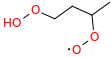

In [63]:
species_list1[i_73_1]

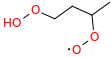

In [64]:
species_list2[i_73_2]

In [66]:
for i in range(len(reaction_list2)):

    if species_list2[i_73_2] in reaction_list2[i].reactants and species_list2[i_70_2] in reaction_list2[i].products or \
            species_list2[i_70_2] in reaction_list2[i].reactants and species_list2[i_73_2] in reaction_list2[i].products:
        print(i, reaction_list2[i])

140 O2(2) + C[CH]CCOO(335) <=> CC(CCOO)O[O](146)
419 C[CH]CCOO(335) + CC(CCOO)OO(148) <=> CC(CCOO)O[O](146) + CCCCOO(226)(21)


In [69]:
reaction_list2[140].kinetics

Arrhenius(A=(1.21695e+14,'cm^3/(mol*s)'), n=-0.429, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-1R->H_N-1CNOS->N_1COS->O_Ext-1O-R_Ext-2R-R_Ext-4R!H-R_Ext-2R-R_N-2R-inRing
Multiplied by reaction path degeneracy 2.0""")

In [70]:
get_i_thing(reaction_list2[140], reaction_list1)

131

In [72]:
reaction_list1[131].kinetics

Arrhenius(A=(1.21695e+14,'cm^3/(mol*s)'), n=-0.429, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-1R->H_N-1CNOS->N_1COS->O_Ext-1O-R_Ext-2R-R_Ext-4R!H-R_Ext-2R-R_N-2R-inRing
Multiplied by reaction path degeneracy 2.0""")

In [ ]:
print(reaction_list1[131])

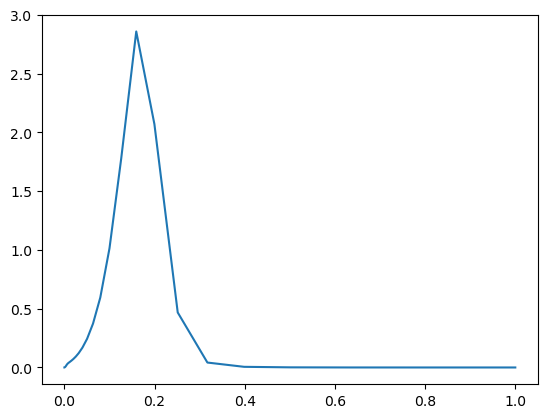

In [67]:
plt.plot(times2, reaction_rates2[:, 140], label='20240423')

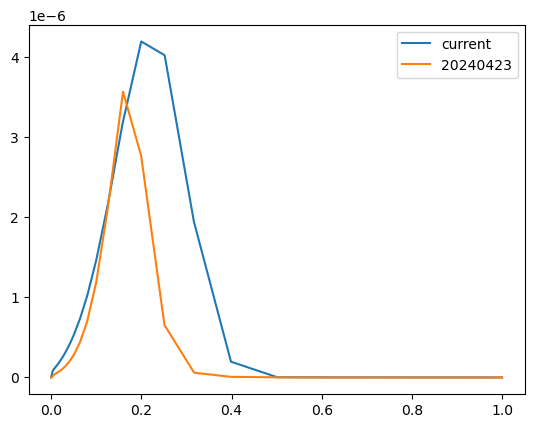

In [65]:
plt.plot(times1, concentrations1[:, i_73_1], label='current')
plt.plot(times2, concentrations2[:, i_73_2], label='20240423')
plt.legend()

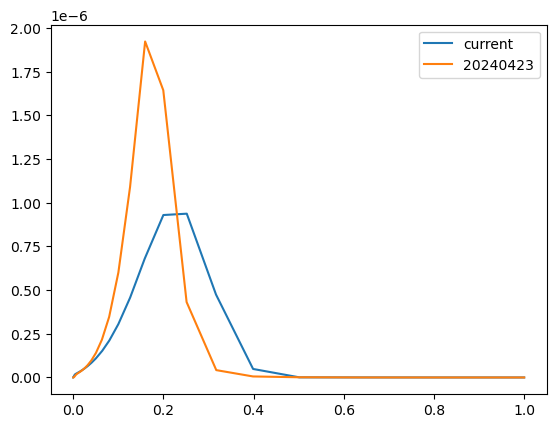

In [55]:
plt.plot(times1, concentrations1[:, i_70_1], label='current')
plt.plot(times2, concentrations2[:, i_70_2], label='20240423')
plt.legend()